In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

Our goal is to load JPEG-encoded photos, decode them, normalize their pixel values, and resize them so that our model can handle them at a constant size. The pixels should be 256 by 256 in size, with the values of each pixel normalized to fall between -1 and 1. When working with models like GANs, this normalization is frequently done because it usually facilitates the training process.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
%matplotlib inline

2024-04-24 02:44:15.759608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 02:44:15.759702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 02:44:15.879537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [6]:
GCS_PATH = KaggleDatasets().get_gcs_path()


Next, we'll define a function to parse our data from the TFRecord format. TFRecord is a flexible and efficient binary storage format often used with TensorFlow. 

In [7]:
monet_files= tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_files= tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

In [8]:
print('No. of Monet TFRecord files: ',len(monet_files))
print('No. of Photo TFRecord files: ',len(photo_files))

No. of Monet TFRecord files:  5
No. of Photo TFRecord files:  20


In [9]:
IMAGE_SIZE = [256, 256]  # Required image size

We need to specify the structure of our data (schema) in a dictionary format to extract it correctly. Once we've read the TFRecord, we'll decode the images using the previously defined function. We then load our dataset, which consists of both Monet-style paintings and photos, into TensorFlow's efficient data pipeline, which allows for easy batching and manipulation.

In [10]:
IMAGE_SIZE= [256,256]                                           

def decode_img(image):                                          
    image= tf.image.decode_jpeg(image,channels= 3)              
    image= (tf.cast(image, tf.float32)/255)*2 -1                
    image= tf.reshape(image, shape= [*IMAGE_SIZE,3])            
    return image

def read_tfrec(example):                                        
    tfrec_format= {
        'image_name': tf.io.FixedLenFeature([], tf.string),     
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example= tf.io.parse_single_example(example, tfrec_format)
    image= decode_img(example['image'])
    return image

In [11]:
def load_data(files):
    """
    Load and preprocess data from a set of file paths.
    """
    data = tf.data.TFRecordDataset(files)
    data = data.map(read_tfrec)  # Apply read_tfrec function to each item
    return data


In [12]:
monet_data= load_data(monet_files).batch(1)                      
photo_data= load_data(photo_files).batch(1)

In [13]:
monet_data


<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [14]:
# Extract examples to display
ex_monet = next(iter(monet_data))
ex_photo = next(iter(photo_data))

After preprocessing our images, we are now ready to visualize them. Visualization is a critical step to ensure that the images have been loaded and processed correctly. We will randomly select images from the Monet and photo datasets and display them side-by-side.

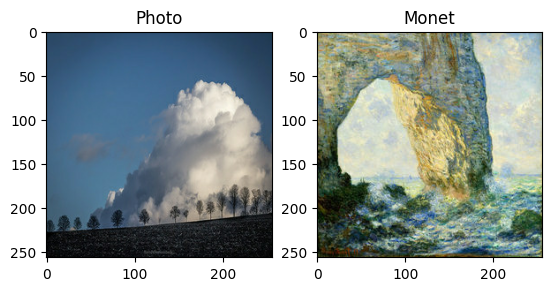

In [15]:
# Display the images
plt.subplot(1, 2, 1) 
# 1 row, 2 columns, 1st subplot
plt.title('Photo')
plt.imshow(ex_photo[0] * 0.5 + 0.5)  
plt.subplot(1, 2, 2) 
# 1 row, 2 columns, 2nd subplot
plt.title('Monet')
plt.imshow(ex_monet[0] * 0.5 + 0.5)

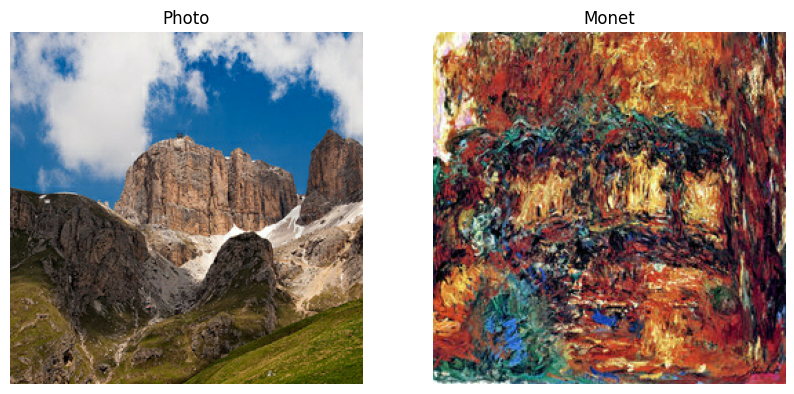

In [16]:
import matplotlib.pyplot as plt
import random

def display_images(monet_dataset, photo_dataset):
    plt.figure(figsize=(10, 5))

    # Get a random batch of Monet images and a random batch of photo images
    monet_batch = next(iter(monet_dataset.shuffle(100)))
    photo_batch = next(iter(photo_dataset.shuffle(100)))

    # Select random images from the batches
    monet_image = monet_batch[random.randint(0, len(monet_batch) - 1)]
    photo_image = photo_batch[random.randint(0, len(photo_batch) - 1)]

    # Display the photo image
    plt.subplot(1, 2, 1)
    plt.title('Photo')
    plt.imshow(photo_image * 0.5 + 0.5)  # Ensure images are normalized if needed
    plt.axis('off')

    # Display the Monet image
    plt.subplot(1, 2, 2)
    plt.title('Monet')
    plt.imshow(monet_image * 0.5 + 0.5)  # Ensure images are normalized if needed
    plt.axis('off')

    plt.show()

# Assuming 'monet_data' and 'photo_data' are TensorFlow datasets or similar
# containing image data. You would call the function like this:
display_images(monet_data, photo_data)


### DATA AUGMENTATION

### Apply the augmentation function to the  images


 We flip images horizontally and vertically to provide mirror variations, promoting orientation invariance without altering artistic content.
 Applying slight rotations offers new angles and perspectives, which helps our model to appreciate and recreate the fluid nature of Monet's compositions.
 By zooming in and out randomly, we simulate the effect of viewing art from varying distances, training our model to capture both minute details and grandiose themes intrinsic to Monet's style.

In [17]:
#def display_augmented_images(dataset, augmentation_fn, num_images=9):
   # """
  #  Apply data augmentation to the dataset and display images.
   # """
  #  plt.figure(figsize=(12, 12))

  #  for i in range(num_images):
   #     # Take a single image from the dataset
    #    for image in dataset.take(1):
     #       # Apply the augmentation function to the image
      #      augmented_image = augmentation_fn(image, training=True)
#
 #           # Plot the augmented image
  #          ax = plt.subplot(3, 3, i + 1)
   #         plt.imshow((augmented_image[0].numpy() + 1) / 2)
    #        plt.axis('off')

    #plt.show()

# Ensure monet_data is batched; if not, use monet_data.batch(1)
#augmented_monet_data = monet_data.map(lambda x: data_augmentation(x, training=True))

# Display different augmented images from the augmented Monet dataset
#display_augmented_images(augmented_monet_data, data_augmentation, num_images=9)


In [18]:
#def display_different_augmented_images(dataset, augmentation_fn, num_images=9):
  #  """
  #  Apply data augmentation to different images from the dataset and display them.
  #  """
  #  plt.figure(figsize=(12, 12))

    # Get different images from the dataset
  #  for i, image in enumerate(dataset.take(num_images)):
        # Apply the augmentation function to the image
     #   augmented_image = augmentation_fn(image, training=True)

        # Plot the augmented image
     #   ax = plt.subplot(3, 3, i + 1)
     #   plt.imshow((augmented_image[0].numpy() + 1) / 2)
      #  plt.axis('off')

  #  plt.show()


#augmented_monet_data = monet_data.map(lambda x: data_augmentation(x, training=True))

# Display different augmented images from the augmented Monet dataset
#display_different_augmented_images(augmented_monet_data, data_augmentation, num_images=9)


In [19]:
#import os
#import tensorflow as tf
#import matplotlib.pyplot as plt

# Define your data augmentation function
#data_augmentation = tf.keras.Sequential([
   # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
   # tf.keras.layers.RandomRotation(0.2),
    #tf.keras.layers.RandomZoom(0.2),
#])

# Define a function to load and preprocess images
#def load_and_preprocess_image(image_path):
  #  image = tf.io.read_file(image_path)
  #  image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [256, 256])
    #image = (image / 127.5) - 1  # Normalize images to [-1, 1]
  #  return image

# Paths to the datasets
#monet_image_paths = [
   # '/kaggle/input/gan-getting-started/monet_jpg/488600cb75.jpg',
   # '/kaggle/input/gan-getting-started/monet_jpg/5185e8c56a.jpg',
    #'/kaggle/input/gan-getting-started/monet_jpg/9963d64ebf.jpg',
    #/kaggle/input/gan-getting-started/monet_jpg/ba52f976af.jpg',
   # '/kaggle/input/gan-getting-started/monet_jpg/158740962c.jpg',
    #'/kaggle/input/gan-getting-started/monet_jpg/1a127acf4d.jpg'
#]
#photo_image_paths = [
 #   '/kaggle/input/gan-getting-started/photo_jpg/4d08cb65c3.jpg',
  #  '/kaggle/input/gan-getting-started/photo_jpg/7594f0f494.jpg',
   # '/kaggle/input/gan-getting-started/photo_jpg/b2633e0b11.jpg',
    #'/kaggle/input/gan-getting-started/photo_jpg/be19b2eac9.jpg',
   # '/kaggle/input/gan-getting-started/photo_jpg/dd232bb32f.jpg',
    #'/kaggle/input/gan-getting-started/photo_jpg/19be535e5f.jpg'
#]

# Create datasets from image paths
#monet_paths_dataset = tf.data.Dataset.from_tensor_slices(monet_image_paths)
#photo_paths_dataset = tf.data.Dataset.from_tensor_slices(photo_image_paths)

# Load and preprocess images, then batch
#num_pairs = 3  # Define the number of image pairs you want to display
#monet_data = monet_paths_dataset.map(load_and_preprocess_image).batch(num_pairs)
#photo_data = photo_paths_dataset.map(load_and_preprocess_image).batch(num_pairs)

# Apply data augmentation to both datasets
#augmented_monet_data = monet_data.map(lambda x: data_augmentation(x, training=True))
#augmented_photo_data = photo_data.map(lambda x: data_augmentation(x, training=True))

# Function to display images
#def display_side_by_side_augmented_images(augmented_monet_data, augmented_photo_data, num_pairs):
 #   plt.figure(figsize=(10, num_pairs * 3))

  #  monet_images = next(iter(augmented_monet_data))
   # photo_images = next(iter(augmented_photo_data))
    
    ##for i in range(num_pairs):
      #  plt.subplot(num_pairs, 2, 2*i + 1)
       # plt.imshow(monet_images[i] * 0.5 + 0.5)
        #plt.title(f'Augmented Monet {i+1}')
       # plt.axis('off')

        #plt.subplot(num_pairs, 2, 2*i + 2)
        #plt.imshow(photo_images[i] * 0.5 + 0.5)
        #plt.title(f'Augmented Photo {i+1}')
        #plt.axis('off')

    #plt.tight_layout()
    #plt.show()

# Display the images
#display_side_by_side_augmented_images(augmented_monet_data, augmented_photo_data, num_pairs)


 These are Monet painting images that have been augmented with the predefined transformations (flips, rotations, zooms). The variations here can simulate different perspectives and compositions, enriching the dataset for the generative model training.
Similarly, these are photo images that have undergone the same augmentations. These alterations serve the same purpose of enhancing the dataset with varied versions of the original images

### DOWNSAMPLING LAYER FUNCTION

we define a function called downsample which creates a sequential model to perform downsampling on an input tensor. Downsampling is a critical part of convolutional neural networks used in GANs, especially the discriminator, as it reduces the spatial dimensions (width and height) of the input. This process helps the network to effectively learn increasingly abstract and high-level features from the input images.

To configure the Conv2D layer, the downsample function requires two parameters: the number of filters and the kernel size. Applying a convolutional layer with a stride of two results in downsampling. As is customary for GANs, we initialize the layer's weights using a random normal initializer that has a mean of 0 and a standard deviation of 0.02.



In [20]:
def downsample(filters, size, apply_instancenorm=True):
    """
    Creates a downsampling layer for a neural network.
    
    Parameters:
    filters (int): Number of filters for the convolutional layers.
    size (int): Kernel size for the convolutional layers.
    apply_instancenorm (bool): If True, adds instance normalization after convolution.
    
    Returns:
    model (tf.keras.Sequential): The downsampling model.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)

    model = keras.Sequential()
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        # Instance normalization acts like batch normalization but on individual images
        model.add(GroupNormalization(groups=-1, epsilon=1e-5, gamma_initializer=gamma_init))

    model.add(LeakyReLU())
    
    return model


### UPSAMPLING LAYER FUNCTION

GANs use layers of upsampling after the downsampling layers to produce high-resolution images from learned features. To do this, we define an upsample function in this code cell. By building a model that executes downsampling in reverse, this method raises the input feature map's resolution.

Transposed convolutions, sometimes referred to as deconvolutions, are a part of the upsampling process. They increase the size of the output image by learning to spread out the input feature map over a greater geographical extent. This is very useful in the generator section of a GAN when we want to gradually build up from a reduced representation of an image to an image with full resolution.



In [21]:
def upsample(filters, size, apply_dropout=False):
    """
    Creates an upsampling layer for a neural network.
    
    Parameters:
    filters (int): Number of filters for the transposed convolutional layers.
    size (int): Kernel size for the transposed convolutional layers.
    apply_dropout (bool): If True, adds dropout regularization to the layer.
    
    Returns:
    model (tf.keras.Sequential): The upsampling model.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)

    model = keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(GroupNormalization(groups=-1, epsilon=1e-5, gamma_initializer=gamma_init))

    if apply_dropout:
        model.add(Dropout(0.5))  # Apply dropout to prevent overfitting

    model.add(ReLU())
    
    return model

 ## BIULDING THE IMAGE GENERATOR

The generator begins with a series of downsampling layers, each consisting of a convolution followed by a leaky ReLU activation. This section of the network gradually reduces the input's spatial dimension while increasing the depth of feature maps, allowing the model to extract and compress relevant features at several levels of abstraction.

As we downsample, we preserve the output of each layer (save the final) to create skip connections. These will be employed later in the upsampling phase, allowing the model to recover spatial information that may have been lost during downsampling.

When we downsample, we keep the output of each layer (save the final) to construct skip connections. These will be used later in the upsampling phase to help the model regain spatial information that was lost during downsampling.

Following the last upsampling step, we use a tanh activation function to perform transposed convolution, which returns the number of channels to three (for RGB images). This produces a final output image of the same size as the input but changed into the desired style.
This architecture, frequently known to as a U-Net due to its characteristic form, is adept at jobs that require understanding and changing complicated visual content, such as style transfer or photo generation in the style of Monet, as is the case here.

In [22]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
import tensorflow as tf


def generator():
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # size=(128, 128, 64)
        downsample(128, 4),  # size=(64, 64, 128)
        downsample(256, 4),  # size=(32, 32, 256)
        downsample(512, 4),  # size=(16, 16, 512)
        downsample(512, 4),  # size=(8, 8, 512)
        downsample(512, 4),  # size=(4, 4, 512)
        downsample(512, 4),  # size=(2, 2, 512)
        downsample(512, 4),  # size=(1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # size=(2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # size=(4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # size=(8, 8, 1024)
        upsample(512, 4),  # size=(16, 16, 1024)
        upsample(256, 4),  # size=(32, 32, 512)
        upsample(128, 4),  # size=(64, 64, 256)
        upsample(64, 4),   # size=(128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                           kernel_initializer=initializer,
                           activation='tanh')  # size=(256, 256, 3)

    inputs = Input(shape=[256, 256, 3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])  
        # Concatenate with corresponding downsample layer

    x = last(x)  
    # Pass through the last layer

    return Model(inputs=inputs, outputs=x)  
# Create the Model instance

# Instantiate the generator model
gen_model = generator()


### BUILD THE DISCRIMINATOR

In [23]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, ZeroPadding2D
import tensorflow as tf


def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

    inputs = Input(shape=[256, 256, 3])
    
    # Downsampling layers
    x = downsample(64, 4, False)(inputs)  # (bs, 128, 128, 64)
    x = downsample(128, 4)(x)  # (bs, 64, 64, 128)
    x = downsample(256, 4)(x)  # (bs, 32, 32, 256)

    # Padding and intermediate conv layer
    x = ZeroPadding2D()(x)  # (bs, 34, 34, 256)
    x = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)  # (bs, 31, 31, 512)
    x = tf.keras.layers.BatchNormalization(gamma_initializer=gamma_init)(x)
    x = LeakyReLU()(x)

    # Padding and final conv layer
    x = ZeroPadding2D()(x)  # (bs, 33, 33, 512)
    x = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)  # (bs, 30, 30, 1)

    return Model(inputs=inputs, outputs=x)

# Create the discriminator model
disc_model = discriminator()


In [24]:
# with strategy.scope():
monet_generator= generator()                     
monet_discriminator= discriminator()             
photo_generator= generator()                     
photo_discriminator= discriminator()   

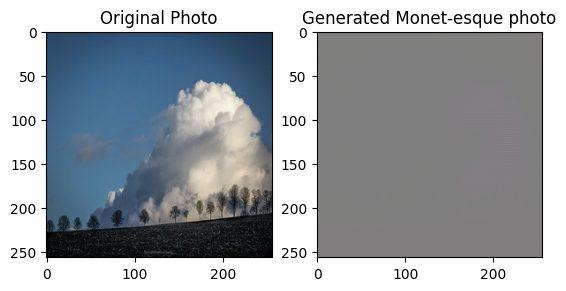

In [25]:
photo_to_monet= monet_generator(ex_photo)                

plt.subplot(1,2,1)                                       
plt.title('Original Photo')
plt.imshow(ex_photo[0]*0.5 +0.5)                         

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 +0.5)   

### CYCLE GAN MODEL

Initialization: The CycleGAN class initializes with generators (monet_gen and photo_gen), discriminators (monet_disc and photo_disc), and a parameter lambda_cycle controlling cycle consistency loss importance.

Compilation: The compile method configures the model for training, setting up optimizers and loss functions for generators and discriminators.

Training Step: The train_step method defines the training logic for one batch of data. It computes losses for generators and discriminators, calculates gradients using tf.GradientTape, and applies gradient descent to update model parameters.

In [26]:
class CycleGAN(keras.Model):                       
    def __init__(self,
                 monet_gen,
                 monet_disc,
                 photo_gen,
                 photo_disc,
                 lambda_cycle=10):
        super(CycleGAN, self).__init__()            
        self.m_gen = monet_gen                      
        self.m_disc = monet_disc
        self.p_gen = photo_gen
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle
        
    def compile(self,
                m_gen_optimizer,
                m_disc_optimizer,
                p_gen_optimizer,
                p_disc_optimizer,
                gen_loss_function,
                disc_loss_function,
                cycle_loss_function,
                identity_loss_function):
        super(CycleGAN, self).compile()             
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function
        
    def train_step(self, batch_data):                                
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:             
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            same_photo = self.p_gen(real_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)      
            
            disc_real_photo = self.p_disc(real_photo, training=True)  
            disc_real_monet = self.m_disc(real_monet, training=True)   
            
            disc_fake_photo = self.p_disc(fake_photo, training=True)  
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            
            gen_monet_loss = self.gen_loss_function(disc_fake_monet)    
            gen_photo_loss = self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) +
                                self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss = (gen_monet_loss + total_cycle_loss +
                                     self.identity_loss_function(real_monet, same_monet, self.lambda_cycle))  
            
            total_gen_photo_loss = (gen_photo_loss + total_cycle_loss +
                                     self.identity_loss_function(real_photo, same_photo, self.lambda_cycle))
            
            disc_monet_loss = self.disc_loss_function(disc_real_monet, disc_fake_monet)  
            disc_photo_loss = self.disc_loss_function(disc_real_photo, disc_fake_photo)  
            
        gen_monet_gradients = tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)  
        gen_photo_gradients = tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)  
        
        disc_monet_gradients = tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)  
        disc_photo_gradients = tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }


Generator Loss (gen_loss_fn):

The generator's objective is to generate images that are indistinguishable from the target domain.
This loss function measures how well the generator fools the discriminator.
It computes the binary cross-entropy loss between the discriminator's predictions on the generated images and a vector of ones (indicating real images)

In [27]:
# with strategy.scope():
def gen_loss_fn(generated):            
    return BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

Discriminator Loss (disc_loss_fn):

The discriminator's goal is to classify real and generated images correctly.
This loss function consists of two parts: one for real images and one for generated images.
For real images, it computes the binary cross-entropy loss between the discriminator's predictions and a vector of ones.
For generated images, it computes the binary cross-entropy loss between the discriminator's predictions and a vector of zeros.

In [28]:
def disc_loss_fn(real, generated):
    loss_real = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    loss_fake = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_loss = (loss_real + loss_fake) / 2
    return total_loss

Identity Loss (identity_loss_fn):

The identity loss encourages generators to preserve the input image's content when it belongs to the same domain.
It measures the difference between the original image and the image generated from the same domain.
This loss helps prevent unnecessary changes to the input image during translation.

In [29]:
# with strategy.scope():
def identity_loss_fn(real, same, Lambda):          
    loss= tf.reduce_mean(tf.abs(real - same))
        
    return Lambda*loss*0.5   

In [30]:
#def identity_loss_fn(real, same, Lambda):
   # loss = tf.reduce_mean(tf.abs(real - same))
    #return Lambda * loss * 0.5


In [31]:
m_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
m_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

p_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
p_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

In [32]:
def cycle_loss_fn(real_image, cycled_image, lambda_cycle=10):
    """Calculate cycle consistency loss as the mean absolute error between the
    original image and the cycled image, scaled by lambda_cycle."""
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss


In [33]:
m_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
m_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

p_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
p_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

In [34]:
cyclegan_model= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, 
                        cycle_loss_fn, identity_loss_fn)

In [35]:
cyclegan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs= 25)


Epoch 1/25


I0000 00:00:1713926847.250713     185 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 160s 147ms/step - disc_monet_loss: 0.6516 - disc_photo_loss: 0.6568 - gen_monet_loss: 5.1630 - gen_photo_loss: 5.2876 - loss: 0.0000e+00
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - disc_monet_loss: 0.6573 - disc_photo_loss: 0.6588 - gen_monet_loss: 3.5657 - gen_photo_loss: 3.5929 - loss: 0.0000e+00
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - disc_monet_loss: 0.6541 - disc_photo_loss: 0.6481 - gen_monet_loss: 3.4156 - gen_photo_loss: 3.4670 - loss: 0.0000e+00
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - disc_monet_loss: 0.6494 - disc_photo_loss: 0.6381 - gen_monet_loss: 3.2350 - gen_photo_loss: 3.3085 - loss: 0.0000e+00
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - disc_monet_loss: 0.6424 - disc_photo_loss: 0.6285 - gen_monet_loss: 3.1071 - gen_photo_loss: 3.1825 - loss: 0.0000e+00
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - disc_monet_loss: 0.6371 - disc_photo_loss: 0.6226 - gen_monet_loss: 3.0082 - gen_photo_loss: 3.0809 - loss: 0.0000e+00
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - disc_monet_loss: 0.6326 - disc_photo_loss: 0.6096 - gen_monet_loss: 2.9683

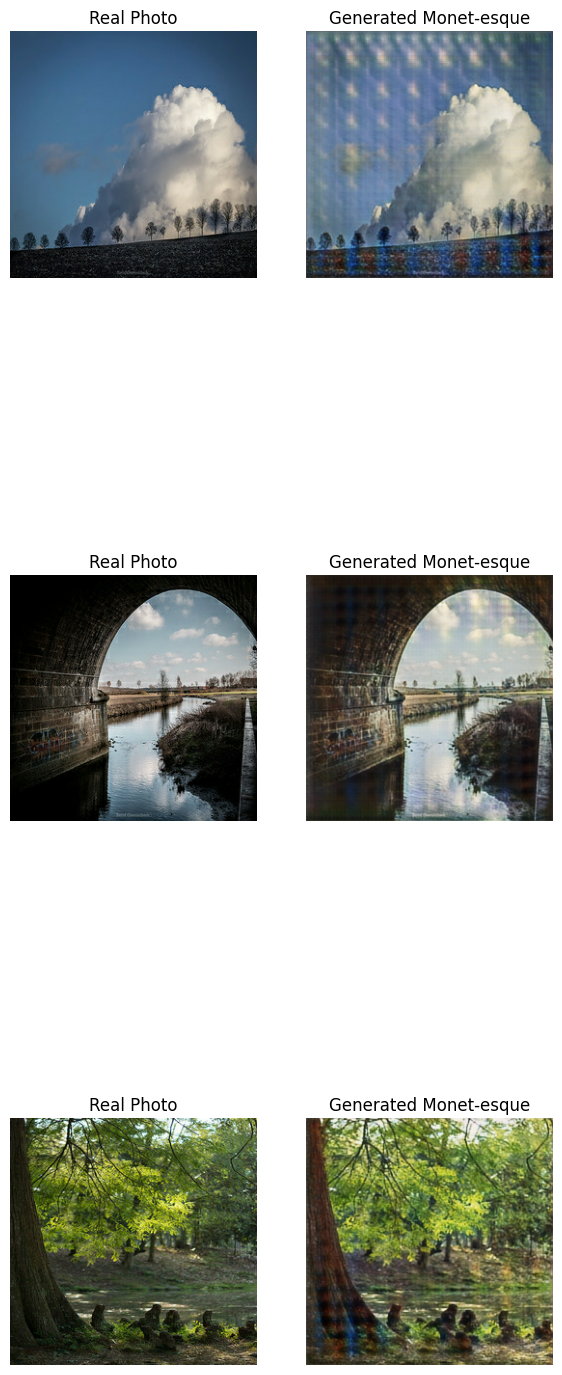

In [37]:
fig,ax= plt.subplots(3,2, figsize=(7,20))
for i,img in enumerate(photo_data.take(3)):
    pred= monet_generator(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Real Photo')
    ax[i,1].set_title('Generated Monet-esque')
    ax[i,0].axis('off')
    ax[i,1].axis('off')